This tutorial shows how to generate an image of handwritten digits using Deep Convolutional Generative Adversarial Network (DCGAN).

Generative Adversarial Networks (GANs) are one of the most interesting fields in machine learning. The standard GAN consists of two models, a generative and a discriminator one. Two models are trained simultaneously by an adversarial process. A generative model (`the artist`) learns to generate images that look real, while the discriminator (`the art critic`) one learns to tell real images apart from the fakes.

![](https://www.tensorflow.org/tutorials/generative/images/gan1.png)

Refer to Tensorflow.org (2020).

During training, the generative model becomes progressively creating images that look real, and the discriminator model becomes progressively telling them apart. The whole process reaches equilibrium when the discriminator is no longer able to distinguish real images from fakes.

![](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

Refer to Tensorflow.org (2020).

In this demo, we show how to train a GAN model on MNIST and FASHION MNIST dataset.


In [0]:
!pip uninstall -y tensorflow
!pip install -q tf-nightly tfds-nightly

In [40]:
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, BatchNormalization, ELU, LeakyReLU, Reshape, Dropout
import numpy as np
import IPython.display as display
from IPython.display import clear_output
import os
import time
import imageio

tfds.disable_progress_bar()

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200420
GPU is available.


# Data Preprocessing

In [0]:
def normalize(image):
  img = image['image']
  img = (tf.cast(img, tf.float32) - 127.5) / 127.5
  return img

## MNIST Dataset

In [52]:
raw_datasets, metadata = tfds.load(name="mnist", with_info=True)
raw_train_datasets, raw_test_datasets = raw_datasets['train'], raw_datasets['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [53]:
raw_test_datasets, metadata

(<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 tfds.core.DatasetInfo(
     name='mnist',
     version=3.0.1,
     description='The MNIST database of handwritten digits.',
     homepage='http://yann.lecun.com/exdb/mnist/',
     features=FeaturesDict({
         'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
         'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
     }),
     total_num_examples=70000,
     splits={
         'test': 10000,
         'train': 60000,
     },
     supervised_keys=('image', 'label'),
     citation="""@article{lecun2010mnist,
       title={MNIST handwritten digit database},
       author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
       journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
       volume={2},
       year={2010}
     }""",
     redistribution_info=,
 ))

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

train_datasets = raw_train_datasets.map(normalize).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_datasets = raw_test_datasets.map(normalize).batch(BATCH_SIZE)

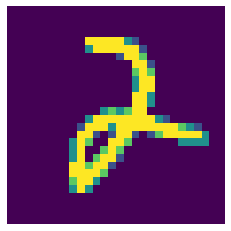

In [58]:
for imgs in train_datasets.take(1):
  img = imgs[0]
  plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
  plt.axis("off")
  plt.show()

## Fashion_MNIST Dataset

In [82]:
raw_datasets, metadata = tfds.load(name="fashion_mnist", with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2U4RLZ/fashion_mnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete2U4RLZ/fashion_mnist-test.tfrecord
Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [83]:
raw_train_datasets, raw_test_datasets = raw_datasets['train'], raw_datasets['test']
raw_train_datasets

<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

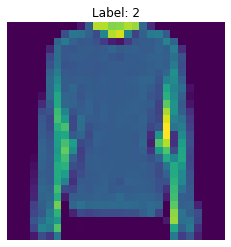

In [84]:
for image in raw_train_datasets.take(1):
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image['image']))
  plt.axis("off")
  plt.title("Label: {}".format(image['label']))
  plt.show()

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

train_datasets = raw_train_datasets.map(normalize).cache().prefetch(BUFFER_SIZE).batch(BATCH_SIZE)
test_datasets = raw_test_datasets.map(normalize).batch(BATCH_SIZE)

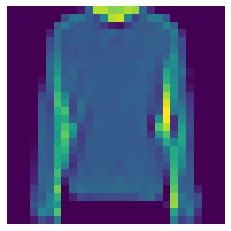

In [86]:
for imgs in train_datasets.take(1):
  img = imgs[0]
  plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
  plt.axis("off")
  plt.show()

# Build the GAN Model

## The Generator

The generator uses the `tf.keras.layers.Conv2DTranspose` (upsampling) layer to produce an image from a seed input (a random noise). Start from this seed input, upsample it several times to reach the desired output (28x28x1).

In [0]:
def build_generator_model():
  model = tf.keras.Sequential()
  
  model.add(Dense(units=7 * 7 * 256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape(target_shape=[7,7,256]))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(Conv2DTranspose(filters=128, kernel_size=(5,5), strides=(1,1), padding="same", use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  assert model.output_shape == (None, 7, 7, 128)

  model.add(Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  assert model.output_shape == (None, 14, 14, 64)

  model.add(Conv2DTranspose(filters=1, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False,
                            activation="tanh"))
  assert model.output_shape == (None, 28, 28, 1)

  return model

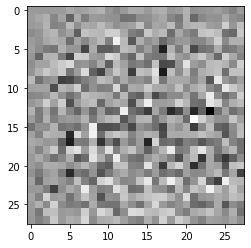

In [88]:
generator = build_generator_model()

generator_input = tf.random.normal(shape=[1, 100])
generator_outputs = generator(generator_input, training=False)

plt.imshow(generator_outputs[0, :, :, 0], cmap='gray')
plt.show()

## The Discriminator

The discriminator is basically a CNN network.

In [0]:
def build_discriminator_model():
  model = tf.keras.Sequential()

  # [None, 28, 28, 64]
  model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding="same", 
                   input_shape=[28,28,1]))
  model.add(LeakyReLU())
  model.add(Dropout(rate=0.3))

  # [None, 14, 14, 128]
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(rate=0.3))

  model.add(Flatten())
  model.add(Dense(units=1))

  return model

The output of the discriminator was trained that the negative values are for the fake images and the positive values are for real ones.

In [90]:
discriminator = build_discriminator_model()
discriminator_outputs = discriminator(generator_outputs)
discriminator_outputs

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00306458]], dtype=float32)>

# Define the losses and optimizers

Define the loss functions and the optimizers for both models.

In [0]:
# define the cross entropy as the helper function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator Loss

The discriminator's loss quantifies how well the discriminator can tell the real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

## Generator Loss

The generator's loss quantifies how well the generator model can trick the discriminator model. If the generator performs well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminator decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
  # the generator learns to make the discriminator predictions became real 
  # (or an array of 1s) on the fake images
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Define optimizers.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

## Save Checkpoints

In [95]:
ckpt_dir = "./gan_ckpt"
ckpt_prefix = os.path.join(ckpt_dir, "ckpt")
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer,
                           generator=generator,
                           discriminator=discriminator)
ckpt

# Define the training loop

In [0]:
EPOCHS = 50
noise_dim = 100
num_generated_examples = 16

# You will reuse the seed overtime to visualize progress in the animated GIF.
seed = tf.random.normal(shape=[num_generated_examples, noise_dim])

In the training loop, the generator model takes the noise as the input to generate the fake images. The discriminator model takes real images and fake images to give the discriminations (or outputs) for them. Calculate the generator and discriminator losses each using the real outputs and the fake outputs. Calculate the gradients of the model trainable variables based on these losses and then apply gradients back to them.

In [0]:
@tf.function
def train_step(images):
  fake_noises = tf.random.normal(shape=[BATCH_SIZE, noise_dim])

  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    fake_images = generator(fake_noises, training=True)

    fake_outputs = discriminator(fake_images, training=True)
    real_outputs = discriminator(images, training=True)

    disc_loss = discriminator_loss(real_output=real_outputs, 
                                   fake_output=fake_outputs)
    gen_loss = generator_loss(fake_output=fake_outputs)

  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
  generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

In [0]:
def generate_and_save_images(model, epoch, test_input):
  """Helps to generate the images from a fixed seed."""
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis("off")
  plt.savefig('image_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for batch_dataset in dataset:
      train_step(batch_dataset)
    
    clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    if (epoch+1) % 15 == 0:
      ckpt.save(file_prefix=ckpt_prefix)
    print("Epoch {} in time {}.".format(epoch + 1, time.time()-start))

  # after the training
  clear_output(wait=True)
  generate_and_save_images(generator, epoch+1, seed)

## Train the Model

Call the `train()` function to start the model training. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g. they train at a similar rate).

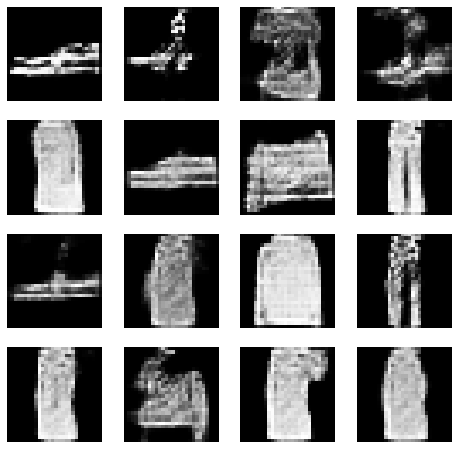

In [100]:
train(train_datasets, epochs=EPOCHS)

# Create a GIF

In [0]:
def display_image(epoch_no):
  image_path = 'image_epoch_{:04d}.png'.format(epoch_no)
  img = plt.imread(fname=image_path)
  plt.imshow(img)
  plt.margins(0)
  plt.axis("off")
  plt.show()

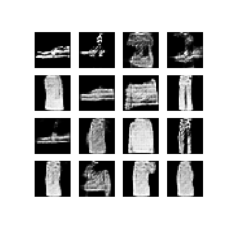

In [102]:
display_image(50)

In [0]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode="I") as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)

  for _, filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)